# Homework 4 - Alberto Trashaj
Download the Nile data, available in the R dataset: and fit a LLM to the data. Compare your results with Table 2.1.

### Import libraries
As usual we import the libraries needed to deal with algebra calculation and to plot the result.

In [1]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import pandas as pd

### Functions
Now, as we did in the Lab, we will define the function of the Kalman filter, the likelihood and the estimator function. 

## Kalman filter

In [6]:
np.random.seed(0)

def KF(y, q):
    
    m20 = y[0]
    P20 = 1 + q
#why p20?
    n = len(y)
    mu_pred = np.empty(n)
    P = np.zeros(n)
    v = np.empty(n)
    K = np.zeros(n)
    F = np.zeros(n)
    dllk = np.empty(n)
    llk = 0

    mu_pred[1] = m20
    P[1] = P20


    for t in range(1, n-1):
        v[t] = y[t] - mu_pred[t]
        F[t] = P[t] + 1
        K[t] = P[t] / F[t]
        P[t + 1] = P[t] * (1 - K[t]) + q
        mu_pred[t + 1] = mu_pred[t] + K[t] * v[t]
        dllk[t] = -0.5 * np.log(F[t])

        #print("Iteration:", t)
        #print("Likelihood:", -0.5 * np.log(F[t]))
        #print("Score:", -K[t])
        #print("Signal-to-Noise Ratio (q):", q)
        #print()

    #Since we need to define sigma_e_hat and the likelihood 
    # we need the last element computed in the for loop, so we retrieve those values below

    F[n - 1] = P[n - 1] + 1
    K[n - 1] = P[n - 1] / F[n - 1]
    dllk[n - 1] = -0.5 * np.log(F[n - 1])
    v[n - 1] = y[n - 1] - mu_pred[n - 1]

    sigma_e_hat = np.sum(v[1:] ** 2 / F[1:]) / (n - 1)
    llk = -0.5 * (n - 1) * np.log(sigma_e_hat) + np.sum(dllk[1:])

    return {'mu_pred': mu_pred, 'llk': llk, 'v': v, 'F': F}


## Loglikelihood 

In [3]:
def loglikelihood(par, y):
    q_new = par[0]
    obj = KF(y, q_new)['llk']
    return -obj

## Estimator 

Here a mention has to be done with the function minimize: in the book, they used the 'BFGS' algorithm, although to get the most similar result to the table I used the 'Nelder-Mead' method just to be consistent with the table 2.1. 
If in the method argument we put 'BFGS' the algorithm converges but not with the same result of the table.

In [7]:
#This uses the Nelder-Mead method
def estimator(y, par):
    n = len(y)
    q_0 = par

    hat = minimize(loglikelihood, q_0, args=(y,), method='Nelder-Mead') #here the method used is the Nelder-Mead although in the book they use BFGS 

    q_hat = hat.x[0]
    theta_list = {'q_hat': q_hat, 'iter': hat.nit}
    out = {'theta_list': theta_list}
    return out

In [8]:
##This uses the BFGS method
def estimator_bfgs(y, par):
    n = len(y)
    q_0 = par

    hat = minimize(loglikelihood, q_0, args=(y,), method='BFGS', tol= 1e-14) #here the method used is the Nelder-Mead although in the book they use BFGS 

    q_hat = hat.x[0]
    theta_list = {'q_hat': q_hat, 'iter': hat.nit}
    out = {'theta_list': theta_list}
    return out


In [9]:
#Load the dataset
np.random.seed(0)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# uncomment those lines above if you get an  URL error message


from statsmodels.datasets import get_rdataset
data = get_rdataset('Nile').data

#data = pd.read_csv("/Users/albertotrashaj/Desktop/Advanced-time-series-github/Assignement 4/Nile.csv")
y = np.array(data['value'])
n = len(y)

q_0 = 1
est = estimator(y, q_0)

#est = estimator_bfgs(y, q_0) uncomment this line and comment the above one to get the result with the BFGS algorithm

q_hat = est['theta_list']['q_hat']

filter_output = KF(y, q_hat)
sigma_e_hat = np.sum(filter_output['v'][1:] ** 2 / filter_output['F'][1:]) / (n - 1)
sigma_eta_hat = q_hat * sigma_e_hat


print("The value of sigma_e_hat is ", sigma_e_hat)
print("The value of sigma_eta_hat is ", sigma_eta_hat)

The value of sigma_e_hat is  15099.46118346705
The value of sigma_eta_hat is  1468.65852917315


/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_76999/3820840896.py:27: RuntimeWarning: invalid value encountered in log
  dllk[t] = -0.5 * np.log(F[t])


### Comment
From the output we can see that the value for the likelihood and the score are different, but the q-ratio and the final values are almost the same of the table 2.1.

# Point 2
Reproduce the Simulation example on Section 2.6.

To reproduce the example on section 2.6. we need to define a data generating process function according to the one used in the book

In [10]:
from math import sqrt

def dgp (n, sigma_e, sigma_eta):
    
    eta = sqrt(sigma_eta)*np.random.normal(0, 1, n)
    e = sqrt(sigma_e)*np.random.normal(0, 1, n)

    alpha = np.zeros(n)
    y = np.zeros(n)
    alpha[0] = 1120
    y[0] = 1120

    for t in range(0, n-1):
        alpha[t+1] = alpha[t] + eta[t]
        y[t+1] = alpha[t+1] + e[t+1]

    out = {'y': np.asarray(y), 'alpha': np.asarray(alpha), 'e': e}

    return out

result = dgp(n, sigma_e_hat, sigma_eta_hat)
y_plus = result['y']
e_plus = result['e']



To find the Kalaman filter vectors we need to define again a function that performs a Kalman filter iteration. Special mention here has to be done for the expression in 2.30 of the book where they define $L_t = 1 - K_t$

In [11]:
def KFL (y, sigma_e, sigma_eta):
    
    # Here we initialize the arrays with 0 elements 

    m10 = y[0]
    p10 = sigma_e 


    n = len(y)
    mu_pred = np.zeros(n)
    P = np.zeros(n)
    v = np.zeros(n)
    K = np.zeros(n)
    F = np.zeros(n)
    L = np.zeros(n)
    mu_pred[0] = m10
    P[0] = p10

    # Start the Kalman filter recursion and add the L[t] term

    for t in range(0, n-1):
        v[t] = y[t] - mu_pred[t] #forecast error 
        F[t] = P[t] + sigma_e;
        K[t] = P[t]/F[t]
        P[t+1] = P[t] + sigma_eta - K[t]*F[t]*K[t]
        mu_pred[t+1] = mu_pred[t] + K[t]*v[t]
        L[t] = 1 - K[t]

    # As before, since the Kalman filter perform the recursion until n-1, we compute manually the last term needed

    F[n-1] = P[n-1] + sigma_e
    K[n-1] = P[n-1]/F[n-1]
    v[n-1] = y[n-1] - mu_pred[n-1]
    L[n-1] = 1 - K[n-1]


    out = {'mu_pred': mu_pred, 'v': v, 'F': F, 'K': K, 'P': P, 'L': L}
    
    return out


    

Now we apply the Kalman filter to the values of the Nile dataset.

In [12]:
filter2 = KFL(y, sigma_e_hat, sigma_eta_hat)

Now we perform the recursion for $r_t$ and $u_t$ 

We first define the backward recursion of $r_t$ as in expression 2.36: namely 

$r_{t-1} = \frac{v_t}{F_t} + L_t \cdot r_t$

In [13]:
v = filter2['v'] #retrieve the elment v from the result of the filtering
F = filter2['F'] #retrieve the elment F from the result of the filtering
L = filter2['L'] #retrieve the elment L from the result of the filtering

r2 = np.zeros(n)

for t in range(n-2, 0, -1):
    r2[t-1] = v[t] / F[t] + L[t] * r2[t] #apply the formula in the for cicle
r2

array([-0.00087115, -0.00404057,  0.00544384, -0.00090046, -0.00402096,
       -0.00753257,  0.01120411,  0.0034137 , -0.01331654, -0.01610969,
       -0.01086676, -0.00270715, -0.00640067, -0.00303435, -0.0016851 ,
        0.00347391, -0.00559924,  0.01001568,  0.0160746 ,  0.01164362,
        0.01099426,  0.00412924,  0.0016395 , -0.00731352, -0.01764017,
       -0.0270335 , -0.02647304, -0.03312341, -0.02140539, -0.01614038,
       -0.01469702, -0.00276222, -0.00738806, -0.00564615,  0.00428861,
        0.00040158,  0.01138858,  0.00176067, -0.00968281, -0.01670367,
       -0.01620982, -0.01033873,  0.01240818,  0.01199025,  0.02081831,
        0.00398818, -0.01112949, -0.0095807 , -0.00446031, -0.00354872,
        0.00052776, -0.00044395, -0.00271716, -0.00512221,  0.00283585,
        0.00133429,  0.00665149,  0.00917182, -0.00357527,  0.00193983,
        0.0061866 ,  0.00547201,  0.0066142 ,  0.0018432 , -0.00539762,
       -0.00740165, -0.00515854, -0.01586795, -0.01229239, -0.00

Here we define the recursion of $u_t$ as in expression 2.45: namely

$u_t = \frac{v_t}{F_t} - K_t \cdot r_t$

In [14]:
v = filter2['v'] 
F = filter2['F']
K = filter2['K']
u2 = np.zeros(n)

for t in range (1, n-1):
    u2[t] = v[t]/F[t] - K[t]*r2[t]
u2


array([ 0.        ,  0.00316941, -0.0094844 ,  0.0063443 ,  0.00312051,
        0.00351161, -0.01873669,  0.00779042,  0.01673024,  0.00279315,
       -0.00524293, -0.00815961,  0.00369352, -0.00336631, -0.00134926,
       -0.00515901,  0.00907316, -0.01561492, -0.00605892,  0.00443098,
        0.00064936,  0.00686502,  0.00248974,  0.00895302,  0.01032665,
        0.00939333, -0.00056047,  0.00665038, -0.01171803, -0.005265  ,
       -0.00144336, -0.0119348 ,  0.00462584, -0.0017419 , -0.00993476,
        0.00388702, -0.010987  ,  0.00962791,  0.01144348,  0.00702086,
       -0.00049385, -0.00587108, -0.02274691,  0.00041793, -0.00882807,
        0.01683013,  0.01511767, -0.00154879, -0.00512039, -0.00091159,
       -0.00407648,  0.00097171,  0.00227321,  0.00240504, -0.00795806,
        0.00150156, -0.0053172 , -0.00252033,  0.01274709, -0.0055151 ,
       -0.00424677,  0.0007146 , -0.00114219,  0.004771  ,  0.00724082,
        0.00200403, -0.00224311,  0.01070941, -0.00357556, -0.00

Now it's possible to define the smoothed disturbaces $\hat{\epsilon_t} = E(\epsilon_t | Y_n)$

$\hat{\epsilon_t} = \sigma^2 \cdot u_t$

where $\sigma$ is the "sigma_e_hat" that we found before.

In [15]:
e_hat = u2 * sigma_e_hat
e_hat

array([   0.        ,   47.85640531, -143.20938384,   95.79547679,
         47.11794434,   53.0233682 , -282.9138569 ,  117.63112489,
        252.61757156,   42.17502422,  -79.16534304, -123.20577686,
         55.77010242,  -50.82950442,  -20.37307478,  -77.89824499,
        136.99976331, -235.77686079,  -91.48646861,   66.90543502,
          9.80493761,  103.65812357,   37.59368172,  135.18581281,
        155.92687648,  141.83426524,   -8.46274754,  100.41710525,
       -176.93590946,  -79.49870599,  -21.79399384, -180.20908813,
         69.847668  ,  -26.30179879, -150.00952648,   58.69197549,
       -165.89781087,  145.37624851,  172.79041956,  106.01115877,
         -7.45686041,  -88.65017578, -343.4661059 ,    6.31051853,
       -133.29906052,  254.125944  ,  228.26866729,  -23.38591483,
        -77.31514257,  -13.76447597,  -61.55261973,   14.67228248,
         34.32429342,   36.3148782 , -120.16234768,   22.67276058,
        -80.28685092,  -38.05561317,  192.47412159,  -83.27502

Again, as before we apply the Kalman filter to the sample Y

In [16]:
filter3 = KFL(y_plus, sigma_e_hat, sigma_eta_hat)

#### $r_t$ and $u_t$
Now we proceed to compute $r_t$ and $u_t$.

For $r_t$ we have from the formula (2.37) that

$r_{t-1} = \frac{v_t}{F_t} + L_t r_t$

In [17]:
v = filter3['v'] 
F = filter3['F']
L = filter3['L']
r3 = np.zeros(n)

for t in range(n-2, 0, -1):
    r3[t-1] = v[t] / F[t] + L[t] * r3[t]

r3

array([ 0.00850716,  0.02007906,  0.03195948,  0.02623616,  0.03481313,
        0.01667211,  0.02181638,  0.02938804,  0.01847052,  0.01321201,
        0.00504669,  0.00483147,  0.01577728,  0.00377329,  0.00955268,
        0.00642323,  0.00189332,  0.00272576, -0.00191484, -0.01004382,
       -0.01254041,  0.00223317,  0.00419103, -0.00400455,  0.00574059,
        0.00584868,  0.01254045,  0.00174518,  0.00117295, -0.00102024,
        0.00253958, -0.00470088, -0.0034822 , -0.00609575,  0.00115871,
       -0.00127049, -0.00340756, -0.00261114, -0.01003824, -0.00534059,
        0.0028454 , -0.00174226, -0.00067593,  0.00084374, -0.01673188,
       -0.02293352, -0.01513917, -0.02215658, -0.01350316, -0.0090195 ,
       -0.00807422, -0.02014014, -0.0151429 , -0.00965736, -0.00803903,
       -0.00253289, -0.01292824, -0.00679278, -0.00153609, -0.00059401,
        0.00170095, -0.0138875 , -0.02193799, -0.02304457, -0.0113261 ,
       -0.01800366, -0.01040138,  0.00475832, -0.00303333, -0.00

For $u_t$ instead from (4.59) we have that

$u_t = \frac{v_t}{F_{t}} - K_t r_t$

In [18]:
v = filter3['v'] 
F = filter3['F']
K = filter3['K']
u3 = np.zeros(n)

for t in range (1, n-1):
    u3[t] = v[t]/F[t] - K[t]*r3[t]
u3

array([ 0.        , -0.0115719 , -0.01188042,  0.00572332, -0.00857697,
        0.01814102, -0.00514427, -0.00757166,  0.01091752,  0.00525851,
        0.00816533,  0.00021521, -0.01094581,  0.01200399, -0.00577939,
        0.00312944,  0.00452991, -0.00083244,  0.0046406 ,  0.00812898,
        0.00249659, -0.01477358, -0.00195785,  0.00819558, -0.00974514,
       -0.00010809, -0.00669177,  0.01079527,  0.00057223,  0.00219319,
       -0.00355982,  0.00724046, -0.00121868,  0.00261355, -0.00725446,
        0.00242919,  0.00213707, -0.00079642,  0.0074271 , -0.00469765,
       -0.00818599,  0.00458766, -0.00106633, -0.00151966,  0.01757562,
        0.00620164, -0.00779435,  0.00701741, -0.00865342, -0.00448366,
       -0.00094528,  0.01206592, -0.00499724, -0.00548554, -0.00161834,
       -0.00550614,  0.01039535, -0.00613546, -0.00525669, -0.00094208,
       -0.00229496,  0.01558845,  0.00805049,  0.00110658, -0.01171848,
        0.00667756, -0.00760227, -0.0151597 ,  0.00779165, -0.00

Now we need to define the following variables:

 -   $\hat{\epsilon}^{+}$ 
 
 -   $\tilde{\epsilon}$                  (2.53)

 -   $\hat{\alpha}$    (2.33)

 -   $\alpha^{+}$

 -   $\tilde{\alpha}$ (2.53)




In [25]:
e_hat_plus = u3 * sigma_e_hat

e_tilde = e_plus - e_hat_plus + e_hat # (2.53)

alpha_tilde = y - e_tilde


alpha = pd.Series(filter2['mu_pred'])
alpha_hat = np.zeros(n)
alpha_hat[0] = alpha[0]
alpha_hat[1] = alpha[1]
for t in range(1, n):
    alpha_hat[t] = alpha[t] + filter2['P'][t] * r2[t-1] # (2.33)



alpha_plus = np.zeros(n)
alpha_plus[0] = 1120
for t in range(1, n):
    alpha_plus[t] = y_plus[t] - e_plus[t]






Now we define the $\tilde{\eta}$ (2.53) and $\hat{\eta}$ to make the plot (iv)

In [26]:
eta_tilde = np.diff(alpha_tilde) #(2.53)
eta_hat = np.diff(alpha_hat) #(2.52)

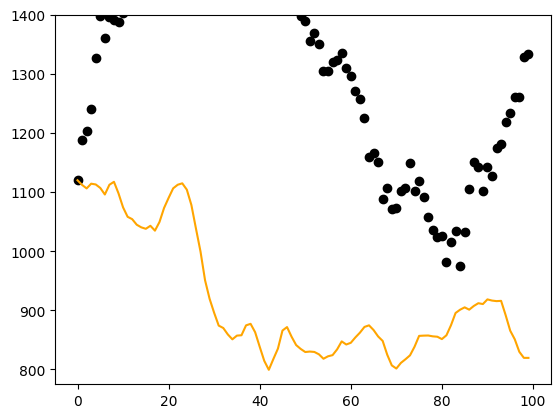

In [35]:
# Graph i

plt.plot(alpha_plus, 'ko',linestyle =  'None')
plt.ylim(775, 1400)
plt.plot(alpha_hat, color='orange')

plt.show()

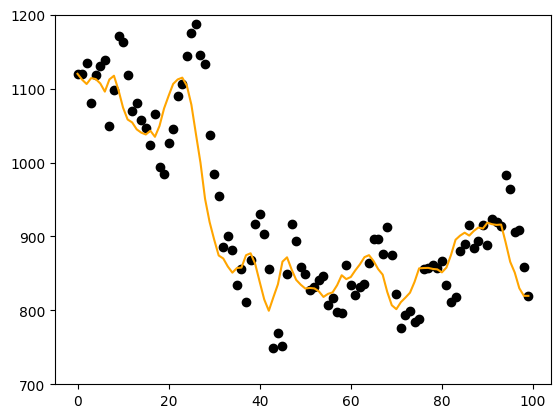

In [28]:
# Graph ii
plt.plot(alpha, 'ko',linestyle =  'None')
plt.ylim(700, 1200)
plt.plot(alpha_hat, color='orange')

plt.show()

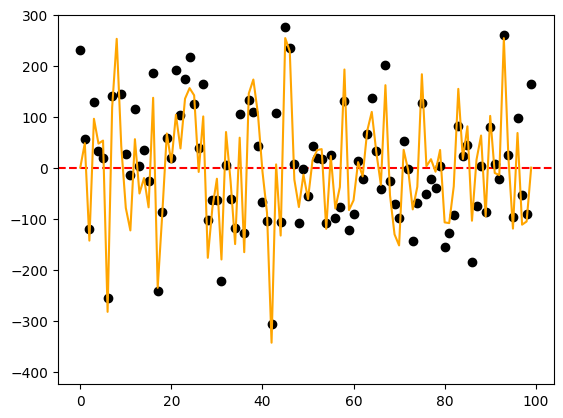

In [29]:
# Graph iii
plt.axhline(np.mean(e_hat), color='red', linestyle='--')
plt.plot(e_tilde, 'ko',linestyle =  'None')
plt.ylim(-425, 300)
plt.plot(e_hat, color='orange')

plt.show()

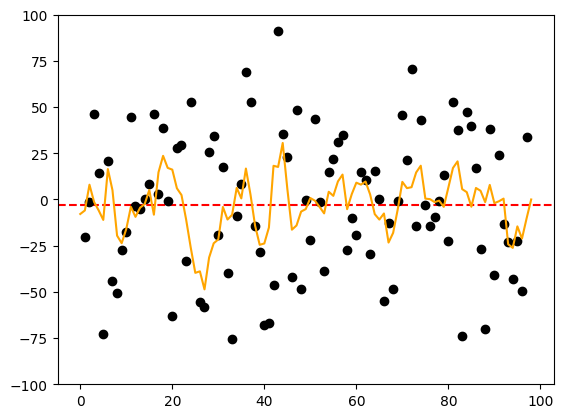

In [30]:
# Graph iiii

plt.axhline(np.mean(eta_hat), color='red', linestyle='--')
plt.plot(eta_tilde, 'ko',linestyle =  'None')
plt.ylim(-100, 100)
plt.plot(eta_hat, color='orange')

plt.show()